<a href="https://colab.research.google.com/github/SongXihao-Alan/Tic-Tac-Toe/blob/main/run_hpc_Version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Module**

In [1]:
from __future__ import absolute_import, division, print_function



In [2]:
'''
This is the version running in HPC, if you want to run in colab, please intall the following module.
'''

!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install imageio>=2.5,<3.0 --upgrade
!pip install imageio imageio-ffmpeg
!pip install pyvirtualdisplay
!pip install tf-agents
!pip install tf-agents[reverb]
!pip install pyglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,063 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,333 kB]
Get:13 https://ppa.launchpadcontent.n

In [10]:
!pip install pydot graphviz


In [3]:

import gym
import base64
import unittest
import IPython
import logging
import matplotlib
import pandas as pd
import reverb
import numpy as np  # 这是python中常用的指令，调用库numpy并在以后重命名为np
import matplotlib.pyplot as plt # 这是python中常用的指令，调用库matplotlib重的pyplot模块并在以后重命名为plt
import tensorflow as tf # 调用tensorflow库
import random

from gym import spaces
from IPython.display import Video
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tf_agents import utils
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.environments import py_environment
from tf_agents.environments import utils
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.eval.metric_utils import log_metrics
from tf_agents.networks import sequential
from tf_agents.networks import network
from tf_agents.networks import q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec
from tf_agents.specs import array_spec
from tf_agents.utils import common
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from collections import deque

In [11]:
from tensorflow.keras.utils import plot_model


## **Environment**

In [4]:
"""
This class represents an environment for a modified Tic-Tac-Toe game with energy management.
It inherits from gym.Env to provide a consistent interface for reinforcement learning.
"""
class EnergyTicTacToeEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    """
    Initializes the game environment.
    Attributes:
        board_size (int): The size of the game board (9x9).
        win_length (int): The number of consecutive marks needed to win.
        action_space (gym.spaces): The space of possible actions (81 discrete actions for the 9x9 grid).
        observation_space (gym.spaces): The space of possible states (9x9 grid with values -1, 0, 1).
        state_size (int): The total number of cells in the board.
        action_size (int): The total number of possible actions.
        energy (dict): Tracks the energy points for each player.
    """

    def __init__(self):
        super(EnergyTicTacToeEnv, self).__init__()
        self.board_size = 9
        self.win_length = 4
        self.action_space = spaces.Tuple((
            spaces.Discrete(self.board_size**2),  # Discrete action for grid cell
            spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  # Continuous action for energy level
        ))
        self.grid_action_size = 81
        self.energy_action_size = 1
        self.state_size = 81
        self.full_state_size = 83
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.board_size, self.board_size), dtype=np.int8)
        self.energy = {1: 10, -1: 10}  # Energy levels for players 1 and -1
        self.reset()
        self.reward = 0

    """
    Resets the environment to the initial state for a new game.
    The state contains board and energy level of two players.
    """
    def reset(self):
        self.state = np.zeros((self.board_size, self.board_size), dtype=np.int8)
        self.current_player = 1
        self.energy = {1: 10, -1: 10}
        self.reward = 0
        return self.get_full_state()

    def get_full_state(self):
        flat_board = self.state.flatten()
        energies = np.array([self.energy[1], self.energy[-1]])
        full_state = np.concatenate((flat_board, energies))
        return full_state

    """
    Executes a step in the environment given an action and energy spent.
    """
    def step(self, action_tuple):
        grid_action, energy_used = action_tuple
        current_energy = self.energy[self.current_player]
        energy_used = min(energy_used[0], current_energy)
        # Deduct the used energy from the current player's total energy
        self.energy[self.current_player] -= energy_used

        # Decode the one-hot encoded grid action to a single integer
        row, col = divmod(grid_action, self.board_size)
        prob_success = 1/9 + (6/9) * energy_used
        # Prob 1/2, the choice is achieved
        if np.random.rand() < prob_success:
            # Attempt to place the mark in the chosen square
            if self.is_valid_move(row, col):
                self.state[row, col] = self.current_player
                if self.almost_winning(self.current_player, row, col):
                    self.reward += 0.8*self.current_player
                winner = self.check_winner()
                self.reward += self.calculate_reward(winner) # Small positive reward for almost winning
                done = winner is not None or not np.any(self.state == 0)
                self.current_player *= -1
                full_state = self.get_full_state()
                return full_state, self.reward, done, {}
            else:
                self.current_player *= -1
                full_state = self.get_full_state()
                winner = None
                done = winner is not None or not np.any(self.state == 0)
                return full_state, self.reward, done, {}
        # Prob 1/2, the choice is random chosen from the neighbors
        else:
            # Mark placement failed, choose from 8 nearby squares
            neighbors = self.get_neighbors(row, col)
            chosen_neighbor = neighbors[np.random.choice(len(neighbors))]
            if self.is_valid_move(*chosen_neighbor):
                self.state[chosen_neighbor] = self.current_player
                if self.almost_winning(self.current_player, row, col):
                    self.reward += 0.8*self.current_player
                winner = self.check_winner()
                self.reward += self.calculate_reward(winner) # Small positive reward for almost winning
                done = winner is not None or not np.any(self.state == 0)
                self.current_player *= -1
                full_state = self.get_full_state()
                return full_state, self.reward, done, {}
            else:
                self.current_player *= -1
                full_state = self.get_full_state()
                winner = None
                done = winner is not None or not np.any(self.state == 0)
                return full_state, self.reward, done, {}


    """
    Finds the neighboring cells around a given cell.
    """
    def get_neighbors(self, row, col):
        neighbors = []
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue  # Skip the original cell
                new_row, new_col = row + dr, col + dc
                neighbors.append((new_row, new_col))
        return neighbors

    """
    Checks if a given cell is within the boundaries of the board.
    """
    def is_on_board(self, row, col):
        return 0 <= row < self.board_size and 0 <= col < self.board_size

    """
    Determines if a move to a given cell is valid.
    """
    def is_valid_move(self, row, col):
        return self.is_on_board(row, col) and self.state[row, col] == 0


    """
    Checks if there's a winner.
    """
    def check_winner(self):
    # Check rows, columns, and diagonals for a win
        for row in range(self.board_size):
            for col in range(self.board_size):
                if self.state[row, col] != 0:  # For each cell that is not empty
                # Checking all eight directions
                    if (self.check_line(row, col, 1, 0) or
                        self.check_line(row, col, 0, 1) or
                        self.check_line(row, col, 1, 1) or
                        self.check_line(row, col, -1, 1) or
                        self.check_line(row, col, -1, -1) or
                        self.check_line(row, col, 1, -1) or
                        self.check_line(row, col, -1, 0) or
                        self.check_line(row, col, 0, -1)):
                        return self.state[row, col]
        return None

    """
    Checks a line of marks from a starting cell in a specified direction.
    """
    def check_line(self, start_row, start_col, d_row, d_col):
        end_row = start_row + (self.win_length - 1) * d_row
        end_col = start_col + (self.win_length - 1) * d_col
        if 0 <= end_row < self.board_size and 0 <= end_col < self.board_size:
            for i in range(self.win_length):
                if self.state[start_row + i * d_row, start_col + i * d_col] != self.state[start_row, start_col]:
                    return False
            return True
        return False

    def calculate_reward(self, winner):
        if winner is None:
            return 0  # No winner yet, or it's a draw
        elif winner == 1:
            return 1  # Player 1 wins, reward is 1
        else:
            return -1  # Player 2 wins, reward is -1

    def getPossibleMoves(self):
        return [i for i in range(self.board_size ** 2) if self.is_valid_move(*divmod(i, self.board_size))]

    # visually rendering the current state of the Tic-Tac-Toe board in the console.
    def render(self, mode='human', close=False):
        if mode == 'rgb_array':
            return self.render_rgb_array()
        else:
            # Correctly indented code block for 'human' mode rendering
            h_line = "+---" * self.board_size + "+"
            print(h_line)
            for row in self.state:
                row_str = "|" + "|".join(' X ' if cell == 1 else ' O ' if cell == -1 else '   ' for cell in row) + "|"
                print(row_str)
                print(h_line)
            if close:
                self.close()

    def render_rgb_array(self):
        # Create an image of the board state
        data = np.zeros((self.board_size, self.board_size, 3), dtype=np.uint8)
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.state[i, j] == 1:
                    data[i, j] = [255, 0, 0]  # Red for player 1
                elif self.state[i, j] == -1:
                    data[i, j] = [0, 0, 255]  # Blue for player 2

        # Convert array to image and resize for better visibility
        img = cv2.resize(data, (300, 300), interpolation=cv2.INTER_NEAREST)
        return img

    def close(self):
        if self.some_resource:  # Check if a certain resource is initialized
            self.some_resource.close()  # Properly close or release the resource
        if self.graphical_interface:  # Check if a graphical interface is used
            self.graphical_interface.destroy()  # Close or destroy the interface

        if self.network_connection:  # Check if there's an open network connection
            self.network_connection.close()  # Close the network connection
        print("Tic-Tac-Toe environment resources have been released.")
        print("Closing Tic-Tac-Toe environment.")

    def almost_winning(self, player, last_move_row, last_move_col):
    # Check in all eight directions from the last move
        for d_row, d_col in [(1, 0), (0, 1), (1, 1), (-1, 1), (-1, -1), (1, -1), (-1, 0), (0, -1)]:
            count = 0  # Count of consecutive marks
            for i in range(-2, 3):  # Check two cells in both directions
                row, col = last_move_row + i * d_row, last_move_col + i * d_col
                if not (0 <= row < self.board_size and 0 <= col < self.board_size):
                    continue  # Skip if the cell is out of the board
                if self.state[row, col] == player:
                    count += 1
                    if count == 3:  # Found 3 in a row
                        return True
                else:
                    count = 0  # Reset count if a different mark is encountered
        return False


## **Hyperparameter**

In [16]:
buffer_size = 100000  # 指定了重播缓冲区的最大长度。重播缓冲区用于存储过去的经验，以便代理可以从中学习。
batch_size = 64 #指定了从重播缓冲区中提取的每个批次的大小，以进行训练。
learning_rate = 0.001  # 学习率，影响了模型权重的更新速度。
gamma = 0.99
max_energy = 10
total_episodes = 500  # 训练次数
total_training_episodes = 500
update_interval = 50
ACTION_ATTEMPTS = 200

In [26]:
#Factor
grid_action_size = 81  # 9x9 Tic-Tac-Toe board
energy_action_size = 1  # Single continuous value for energy
full_state_size = 83

## **Network**

### **Actor Network**

In [54]:
'''
Actor Network
The Actor network's role is to propose actions given the current state of the environment.
Discrete Action Output: A probability distribution over the grid positions.
Continuous Action Output: A value representing the energy level to use.
'''


class Actor(tf.keras.Model):
    def __init__(self, full_state_size, grid_action_size, energy_action_size):
        super(Actor, self).__init__()
        self.dense1 = tf.keras.layers.Dense(128, activation='LeakyReLU', input_shape=(full_state_size,))
        self.dropout1 = tf.keras.layers.Dropout(0.2)
        self.batch_norm1 = tf.keras.layers.BatchNormalization()

        self.dense2 = tf.keras.layers.Dense(128, activation='LeakyReLU')
        self.dropout2 = tf.keras.layers.Dropout(0.2)
        self.batch_norm2 = tf.keras.layers.BatchNormalization()

        self.dense3 = tf.keras.layers.Dense(64, activation='LeakyReLU')
        self.dropout3 = tf.keras.layers.Dropout(0.2)
        self.batch_norm3 = tf.keras.layers.BatchNormalization()

        self.grid_action = tf.keras.layers.Dense(grid_action_size, activation='softmax')
        self.energy_action = tf.keras.layers.Dense(energy_action_size, activation='sigmoid')

    def call(self, state):
        x = self.dense1(state)
        #x = self.dropout1(x)
        x = self.batch_norm1(x)

        x = self.dense2(x)
        x = self.dropout2(x)
        x = self.batch_norm2(x)

        x = self.dense3(x)
        x = self.dropout3(x)
        x = self.batch_norm3(x)

        grid_action_probs = self.grid_action(x)
        energy_level = self.energy_action(x)
        return grid_action_probs, energy_level

### **Critic Network**

In [55]:
'''
The Critic network evaluates the actions taken by the Actor by predicting the expected returns (Q-values) of the state-action pairs.
The Critic takes both the state and the action as input and outputs a single Q-value.
'''
class Critic(tf.keras.Model):
    def __init__(self, full_state_size, grid_action_size, energy_action_size):
        super(Critic, self).__init__()
        self.state_dense = tf.keras.layers.Dense(128, activation='LeakyReLU', input_shape=(full_state_size,))
        self.dropout_state = tf.keras.layers.Dropout(0.2)
        self.state_batch_norm = tf.keras.layers.BatchNormalization()

        # Save these sizes as attributes
        self.grid_action_size = grid_action_size
        self.energy_action_size = energy_action_size

        self.grid_action_dense = tf.keras.layers.Dense(128, activation='LeakyReLU')
        self.energy_action_dense = tf.keras.layers.Dense(128, activation='LeakyReLU')

        self.concat_layer = tf.keras.layers.Concatenate()
        self.dense2 = tf.keras.layers.Dense(128, activation='LeakyReLU')
        self.dropout2 = tf.keras.layers.Dropout(0.2)
        self.batch_norm2 = tf.keras.layers.BatchNormalization()

        #self.dense3 = tf.keras.layers.Dense(128, activation='LeakyReLU')
        #self.dropout3 = tf.keras.layers.Dropout(0.2)
        #self.batch_norm3 = tf.keras.layers.BatchNormalization()

        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, state, grid_action, energy_action):
        state_path = self.state_dense(state)
        #state_path = self.dropout_state(state_path)
        state_path = self.state_batch_norm(state_path)

        # Use the saved attribute sizes here
        grid_action = tf.reshape(grid_action, [-1, self.grid_action_size])
        energy_action = tf.reshape(energy_action, [-1, self.energy_action_size])

        grid_action_path = self.grid_action_dense(grid_action)
        energy_action_path = self.energy_action_dense(energy_action)

        combined = self.concat_layer([state_path, grid_action_path, energy_action_path])
        x = self.dense2(combined)
        x = self.dropout2(x)
        x = self.batch_norm2(x)

        #x = self.dense3(combined)
        #x = self.dropout3(x)
        #x = self.batch_norm3(x)
        return self.output_layer(x)


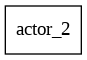

In [18]:


actor_model = Actor(full_state_size, grid_action_size, energy_action_size)

# Create a dummy input data with the correct shape
sample_input = np.random.random((1, full_state_size))
actor_model(sample_input)  # Call the model to build it

# Now plot the model
plot_model(actor_model, to_file='actor_model.png', show_shapes=True, show_layer_names=True)

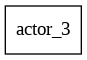

In [19]:
# Create an instance of the model
actor_model = Actor(full_state_size, grid_action_size, energy_action_size)

# Manually build the model
actor_model.build(input_shape=(None, full_state_size))

# Generate and display the plot
plot_model(actor_model, to_file='actor_model.png', show_shapes=True, show_layer_names=True)

## **Replay Buffer**

In [29]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

## **Actor-Critic Agent**

In [25]:
# Actor-Critic Agent

class ActorCriticAgent:
    def __init__(self, full_state_size, grid_action_size, energy_action_size, buffer_size, batch_size, learning_rate):
        self.full_state_size = full_state_size
        self.grid_action_size = grid_action_size
        self.energy_action_size = energy_action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.update_interval = update_interval

        self.actor = Actor(full_state_size, grid_action_size, energy_action_size)
        self.critic = Critic(full_state_size, grid_action_size, energy_action_size)
        self.target_critic = Critic(full_state_size, grid_action_size, energy_action_size)
        self.target_critic.set_weights(self.critic.get_weights())

        #self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate)
        #self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.actor_optimizer = RMSprop(learning_rate=learning_rate)
        self.critic_optimizer = RMSprop(learning_rate=learning_rate)

        self.memory = ReplayBuffer(buffer_size)
        self.step_counter = 0
        self.gamma = gamma

    def act(self, state, env):
        state = np.reshape(state, [1, self.full_state_size]).astype(np.float32)
        grid_action_probs, energy_level = self.actor(state)
        probabilities = grid_action_probs[0].numpy()
        MAX_ACTION_ATTEMPTS = ACTION_ATTEMPTS
        # Check for numerical stability
        if np.isnan(probabilities).any() or np.isinf(probabilities).any():
            probabilities = np.full(self.grid_action_size, 1 / self.grid_action_size)

        # Action selection loop to handle invalid actions
        for _ in range(MAX_ACTION_ATTEMPTS):
            chosen_grid_action = np.random.choice(self.grid_action_size, p=probabilities)
            energy = energy_level[0][0].numpy()
            if env.is_valid_move(*divmod(chosen_grid_action, env.board_size)):
                return chosen_grid_action, energy
        # Fallback if a valid action is not found
        return self.fallback_action_strategy(env)

    def remember(self, state, action, reward, next_state, done):
        # Ensure grid action is stored in one-hot encoded format
        one_hot_grid_action = np.zeros((1, self.grid_action_size))
        one_hot_grid_action[0, action[0]] = 1
        one_hot_action = (one_hot_grid_action, action[1])  # action[1] is energy action
        self.memory.add(state, one_hot_action, reward, next_state, done)

    def replay(self):
        minibatch = self.memory.sample(self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.reshape(state, [1, self.full_state_size])
            next_state = np.reshape(next_state, [1, self.full_state_size])

            # Split the action into grid action and energy level
            grid_action, energy_action = action
            grid_action = np.reshape(grid_action, [1, -1])  # Reshape for processing
            energy_action = np.reshape(energy_action, [1, -1])  # Reshape for processing

            # Critic update
            target_action_grid, target_action_energy = self.actor(next_state)
            target_critic_val = self.target_critic(next_state, target_action_grid, target_action_energy)
            critic_target = reward + (self.gamma * target_critic_val * (1 - int(done)))

            with tf.GradientTape() as tape:
                current_critic_val = self.critic(state, grid_action, energy_action)
                critic_loss = tf.keras.losses.MSE(critic_target, current_critic_val)
            critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

            # Actor update
            with tf.GradientTape() as tape:
                actions_grid, actions_energy = self.actor(state)
                critic_value = self.critic(state, actions_grid, actions_energy)
                actor_loss = -tf.math.reduce_mean(critic_value)
            actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

            self.step_counter += 1
            if self.step_counter % self.update_interval == 0:
                self.update_target_models()


    def update_target_models(self):
        self.target_critic.set_weights(self.critic.get_weights())

    def fallback_action_strategy(self, env):
        valid_actions = [i for i in range(self.grid_action_size) if env.is_valid_move(*divmod(i, env.board_size))]
        if not valid_actions:  # If no valid actions are available
            return None  # or handle this situation appropriately
        chosen_grid_action = random.choice(valid_actions)
        # Assuming energy level is continuous from 0 to 1, select random energy
        energy = random.uniform(0, 1)
        return chosen_grid_action, energy

In [22]:
def random_policy(env):
    # Generate a valid grid action
    possible_action =  env.getPossibleMoves()
    grid_action = random.choice(possible_action) if possible_action else None

    # Generate an energy level within the allowed range
    # Assuming the energy level can range from 0 to some max_energy
    energy = random.uniform(0, min(1, env.energy[env.current_player]))

    return (grid_action, np.array([energy], dtype=np.float32))

## **Training**

In [21]:
#Train agent vs same actor-critic agent
# Initialize Environment and Agent
env = EnergyTicTacToeEnv()
agent = ActorCriticAgent(env.full_state_size, env.grid_action_size, env.energy_action_size, buffer_size, batch_size, learning_rate)

# Variables to track the number of wins, losses, and draws
player_1_wins, player_2_wins, draws = 0, 0, 0  # Reset the win/draw counters

for episode in range(total_training_episodes):
    state = env.reset()
    state = np.reshape(state, [1, env.full_state_size])
    while True:

        chosen_grid_action, energy = agent.act(state, env)  # Get the chosen grid action and energy
        # Combine the grid action and energy level to form the complete action
        action = (chosen_grid_action, np.array([energy], dtype=np.float32))
        next_state, reward, done, _ = env.step(action)
        #next_state = np.reshape(next_state, [1, env.full_state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            winner = env.check_winner()
            if winner == 1:
                player_1_wins += 1
            elif winner == -1:
                player_2_wins += 1
            else:
                draws += 1
            break

    # Replay and Update the target model
    if len(agent.memory) > agent.batch_size:
        agent.replay()

    print(f"Episode {episode + 1}: Player 1 Wins - {player_1_wins}, Player 2 Wins - {player_2_wins}, Draws - {draws}, Reward - {reward}")
print('Finish')

Episode 1: Player 1 Wins - 1, Player 2 Wins - 0, Draws - 0, Reward - 1.8
Episode 2: Player 1 Wins - 1, Player 2 Wins - 1, Draws - 0, Reward - -0.19999999999999996
Episode 3: Player 1 Wins - 2, Player 2 Wins - 1, Draws - 0, Reward - 1.0
Episode 4: Player 1 Wins - 2, Player 2 Wins - 2, Draws - 0, Reward - -1.8
Episode 5: Player 1 Wins - 2, Player 2 Wins - 3, Draws - 0, Reward - -0.19999999999999996
Episode 6: Player 1 Wins - 3, Player 2 Wins - 3, Draws - 0, Reward - 1.8
Episode 7: Player 1 Wins - 4, Player 2 Wins - 3, Draws - 0, Reward - 1.8
Episode 8: Player 1 Wins - 5, Player 2 Wins - 3, Draws - 0, Reward - 2.6
Episode 9: Player 1 Wins - 6, Player 2 Wins - 3, Draws - 0, Reward - -2.2
Episode 10: Player 1 Wins - 6, Player 2 Wins - 4, Draws - 0, Reward - -0.19999999999999996
Episode 11: Player 1 Wins - 6, Player 2 Wins - 5, Draws - 0, Reward - -1.8
Episode 12: Player 1 Wins - 6, Player 2 Wins - 6, Draws - 0, Reward - -1
Episode 13: Player 1 Wins - 7, Player 2 Wins - 6, Draws - 0, Reward 

AttributeError: 'ActorCriticAgent' object has no attribute 'save'

## **Evaluate**

In [53]:
# Evaluate the performance of agent vs agent with random policy
# Load the trained model
# Initialize Environment and Agent
env = EnergyTicTacToeEnv()
#agent.load(model_save_path)
agent = ActorCriticAgent(env.full_state_size, env.grid_action_size, env.energy_action_size, buffer_size, batch_size, learning_rate)

#print("Loaded trained model.")

# Evaluation
player_1_wins, player_2_wins, draws = 0, 0, 0  # Reset the win/draw counters

# Variables for plotting
win_rate_version2 = []
draw_rate_version2 = []
lose_rate_version2 = []
x_axis_version2 = []

for episode in range(total_episodes):
    state = env.reset()
    state = np.reshape(state, [1, env.full_state_size])
    player_turn = 1
    while True:
        current_player = env.current_player  # Get the current player from the environment
        if current_player == 1:  # Actor-Critic Agent (Player 1)
            chosen_grid_action, energy = agent.act(state, env)  # Get the chosen grid action and energy
            action = (chosen_grid_action, np.array([energy], dtype=np.float32))
        else:  # Random Policy (Player -1)
            action = random_policy(env)

        # Execute the action and get the next state
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, env.full_state_size])

        # If player 1 made a move, remember the action
        if current_player == 1:
            agent.remember(state, action, reward, next_state, done)

        # Update the state for the next iteration
        state = next_state

        if done:
            winner = env.check_winner()
            if winner == 1:
                player_1_wins += 1
            elif winner == -1:
                player_2_wins += 1
            else:
                draws += 1
            break

    # Replay and Update the target model
    if len(agent.memory) > agent.batch_size:
        agent.replay()

    # Update and statistics
    total_rounds = episode + 1
    win_rate_version2.append(player_1_wins / total_rounds)
    draw_rate_version2.append(draws / total_rounds)
    lose_rate_version2.append(player_2_wins / total_rounds)
    x_axis_version2.append(total_rounds)

    print(f"Episode {episode + 1}: Player 1 Wins - {player_1_wins}, Player 2 Wins - {player_2_wins}, Draws - {draws}, Reward - {reward}")

print(f"Episode {total_rounds}: Player 1 Wins - {player_1_wins}, Player 2 Wins - {player_2_wins}, Draws - {draws}, Reward - {reward}")

Episode 1: Player 1 Wins - 0, Player 2 Wins - 1, Draws - 0, Reward - -1.0
Episode 2: Player 1 Wins - 1, Player 2 Wins - 1, Draws - 0, Reward - 2.6
Episode 3: Player 1 Wins - 1, Player 2 Wins - 2, Draws - 0, Reward - -0.19999999999999996
Episode 4: Player 1 Wins - 1, Player 2 Wins - 3, Draws - 0, Reward - -1.8
Episode 5: Player 1 Wins - 1, Player 2 Wins - 4, Draws - 0, Reward - -2.6
Episode 6: Player 1 Wins - 1, Player 2 Wins - 5, Draws - 0, Reward - -1
Episode 7: Player 1 Wins - 2, Player 2 Wins - 5, Draws - 0, Reward - -0.6000000000000001
Episode 8: Player 1 Wins - 2, Player 2 Wins - 6, Draws - 0, Reward - -1.8
Episode 9: Player 1 Wins - 3, Player 2 Wins - 6, Draws - 0, Reward - 2.6
Episode 10: Player 1 Wins - 4, Player 2 Wins - 6, Draws - 0, Reward - 2.6
Episode 11: Player 1 Wins - 4, Player 2 Wins - 7, Draws - 0, Reward - -1.0
Episode 12: Player 1 Wins - 4, Player 2 Wins - 8, Draws - 0, Reward - -1.8
Episode 13: Player 1 Wins - 5, Player 2 Wins - 8, Draws - 0, Reward - 1
Episode 14:

KeyboardInterrupt: 

## **Compare-RMSprop Optimizer**

In [ ]:
# Actor-Critic Agent

class ActorCriticAgent_RMS:
    def __init__(self, full_state_size, grid_action_size, energy_action_size, buffer_size, batch_size, learning_rate):
        self.full_state_size = full_state_size
        self.grid_action_size = grid_action_size
        self.energy_action_size = energy_action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.update_interval = update_interval

        self.actor = Actor(full_state_size, grid_action_size, energy_action_size)
        self.critic = Critic(full_state_size, grid_action_size, energy_action_size)
        self.target_critic = Critic(full_state_size, grid_action_size, energy_action_size)
        self.target_critic.set_weights(self.critic.get_weights())

        self.actor_optimizer = RMSprop(learning_rate=learning_rate)
        self.critic_optimizer = RMSprop(learning_rate=learning_rate)

        self.memory = ReplayBuffer(buffer_size)
        self.step_counter = 0
        self.gamma = gamma

    def act(self, state, env):
        state = np.reshape(state, [1, self.full_state_size]).astype(np.float32)
        grid_action_probs, energy_level = self.actor(state)
        probabilities = grid_action_probs[0].numpy()
        MAX_ACTION_ATTEMPTS = ACTION_ATTEMPTS
        # Check for numerical stability
        if np.isnan(probabilities).any() or np.isinf(probabilities).any():
            probabilities = np.full(self.grid_action_size, 1 / self.grid_action_size)

        # Action selection loop to handle invalid actions
        for _ in range(MAX_ACTION_ATTEMPTS):
            chosen_grid_action = np.random.choice(self.grid_action_size, p=probabilities)
            energy = energy_level[0][0].numpy()
            if env.is_valid_move(*divmod(chosen_grid_action, env.board_size)):
                return chosen_grid_action, energy
        # Fallback if a valid action is not found
        return self.fallback_action_strategy(env)


    def remember(self, state, action, reward, next_state, done):
        # Ensure grid action is stored in one-hot encoded format
        one_hot_grid_action = np.zeros((1, self.grid_action_size))
        one_hot_grid_action[0, action[0]] = 1
        one_hot_action = (one_hot_grid_action, action[1])  # action[1] is energy action
        self.memory.add(state, one_hot_action, reward, next_state, done)

    def replay(self):
        minibatch = self.memory.sample(self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.reshape(state, [1, self.full_state_size])
            next_state = np.reshape(next_state, [1, self.full_state_size])

            # Split the action into grid action and energy level
            grid_action, energy_action = action
            grid_action = np.reshape(grid_action, [1, -1])  # Reshape for processing
            energy_action = np.reshape(energy_action, [1, -1])  # Reshape for processing

            # Critic update
            target_action_grid, target_action_energy = self.actor(next_state)
            target_critic_val = self.target_critic(next_state, target_action_grid, target_action_energy)
            critic_target = reward + (self.gamma * target_critic_val * (1 - int(done)))

            with tf.GradientTape() as tape:
                current_critic_val = self.critic(state, grid_action, energy_action)
                critic_loss = tf.keras.losses.MSE(critic_target, current_critic_val)
            critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

            # Actor update
            with tf.GradientTape() as tape:
                actions_grid, actions_energy = self.actor(state)
                critic_value = self.critic(state, actions_grid, actions_energy)
                actor_loss = -tf.math.reduce_mean(critic_value)
            actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

            self.step_counter += 1
            if self.step_counter % self.update_interval == 0:
                self.update_target_models()

    def update_target_models(self):
        self.target_critic.set_weights(self.critic.get_weights())

    def fallback_action_strategy(self, env):
        valid_actions = [i for i in range(self.grid_action_size) if env.is_valid_move(*divmod(i, env.board_size))]
        if not valid_actions:  # If no valid actions are available
            return None  # or handle this situation appropriately
        chosen_grid_action = random.choice(valid_actions)
        # Assuming energy level is continuous from 0 to 1, select random energy
        energy = random.uniform(0, 1)
        return chosen_grid_action, energy

In [ ]:
# Evaluate the performance of agent vs agent with random policy

# Initialize Environment and Agent
env = EnergyTicTacToeEnv()
agent = ActorCriticAgent_RMS(env.full_state_size, env.grid_action_size, env.energy_action_size, buffer_size, batch_size, learning_rate)
# Evaluation
player_1_wins, player_2_wins, draws = 0, 0, 0  # Reset the win/draw counters

# Variables for plotting
win_rate_version2_RM = []
draw_rate_version2_RM = []
lose_rate_version2_RM = []
x_axis_version2_RM = []

for episode in range(total_episodes):
    state = env.reset()
    state = np.reshape(state, [1, env.full_state_size])
    player_turn = 1
    while True:
        current_player = env.current_player  # Get the current player from the environment
        if current_player == 1:  # Actor-Critic Agent (Player 1)
            chosen_grid_action, energy = agent.act(state, env)  # Get the chosen grid action and energy
            action = (chosen_grid_action, np.array([energy], dtype=np.float32))
        else:  # Random Policy (Player -1)
            action = random_policy(env)

        # Execute the action and get the next state
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, env.full_state_size])

        # If player 1 made a move, remember the action
        if current_player == 1:
            agent.remember(state, action, reward, next_state, done)

        # Update the state for the next iteration
        state = next_state

        if done:
            winner = env.check_winner()
            if winner == 1:
                player_1_wins += 1
            elif winner == -1:
                player_2_wins += 1
            else:
                draws += 1
            break

    # Replay and Update the target model
    if len(agent.memory) > agent.batch_size:
        agent.replay()

    # Update and statistics
    total_rounds = episode + 1
    win_rate_version2_RM.append(player_1_wins / total_rounds)
    draw_rate_version2_RM.append(draws / total_rounds)
    lose_rate_version2_RM.append(player_2_wins / total_rounds)
    x_axis_version2_RM.append(total_rounds)

    print(f"Episode {episode + 1}: Player 1 Wins - {player_1_wins}, Player 2 Wins - {player_2_wins}, Draws - {draws}, Reward - {reward}")

print(f"Episode {total_rounds}: Player 1 Wins - {player_1_wins}, Player 2 Wins - {player_2_wins}, Draws - {draws}, Reward - {reward}")

Episode 1: Player 1 Wins - 1, Player 2 Wins - 0, Draws - 0, Reward - 1.8
Episode 2: Player 1 Wins - 1, Player 2 Wins - 1, Draws - 0, Reward - 0.6000000000000001
Episode 3: Player 1 Wins - 2, Player 2 Wins - 1, Draws - 0, Reward - 2.6
Episode 4: Player 1 Wins - 2, Player 2 Wins - 2, Draws - 0, Reward - -1.0
Episode 5: Player 1 Wins - 2, Player 2 Wins - 3, Draws - 0, Reward - -0.19999999999999996
Episode 6: Player 1 Wins - 3, Player 2 Wins - 3, Draws - 0, Reward - 2.6
Episode 7: Player 1 Wins - 4, Player 2 Wins - 3, Draws - 0, Reward - 1.8
Episode 8: Player 1 Wins - 4, Player 2 Wins - 4, Draws - 0, Reward - -1.0
Episode 9: Player 1 Wins - 4, Player 2 Wins - 5, Draws - 0, Reward - -0.19999999999999996
Episode 10: Player 1 Wins - 5, Player 2 Wins - 5, Draws - 0, Reward - 2.6
Episode 11: Player 1 Wins - 6, Player 2 Wins - 5, Draws - 0, Reward - 2.6
Episode 12: Player 1 Wins - 7, Player 2 Wins - 5, Draws - 0, Reward - 0.19999999999999996
Episode 13: Player 1 Wins - 7, Player 2 Wins - 6, Draw

## **Compare-Adam Optimizer**


In [ ]:
# Actor-Critic Agent

class ActorCriticAgent_Adam:
    def __init__(self, full_state_size, grid_action_size, energy_action_size, buffer_size, batch_size, learning_rate):
        self.full_state_size = full_state_size
        self.grid_action_size = grid_action_size
        self.energy_action_size = energy_action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.update_interval = update_interval

        self.actor = Actor(full_state_size, grid_action_size, energy_action_size)
        self.critic = Critic(full_state_size, grid_action_size, energy_action_size)
        self.target_critic = Critic(full_state_size, grid_action_size, energy_action_size)
        self.target_critic.set_weights(self.critic.get_weights())

        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate)

        self.memory = ReplayBuffer(buffer_size)
        self.step_counter = 0
        self.gamma = gamma

    #def act(self, state, env):
    #    if np.random.rand() <= self.epsilon:
    #        chosen_grid_action = np.random.choice(self.grid_action_size)
    #        energy = np.random.uniform(0, 1)
    #        return chosen_grid_action, energy
    #    else:
    #        state = np.reshape(state, [1, self.full_state_size]).astype(np.float32)
    #        grid_action_probs, energy_level = self.actor(state)
    #        probabilities = grid_action_probs[0].numpy()
    #        MAX_ACTION_ATTEMPTS = ACTION_ATTEMPTS
    #        if np.isnan(probabilities).any() or np.isinf(probabilities).any():
    #            probabilities = np.full(self.grid_action_size, 1 / self.grid_action_size)
    #        for _ in range(MAX_ACTION_ATTEMPTS):
    #            chosen_grid_action = np.random.choice(self.grid_action_size, p=probabilities)
    #            energy = energy_level[0][0].numpy()
    #            if env.is_valid_move(*divmod(chosen_grid_action, env.board_size)):
    #                return chosen_grid_action, energy
    #        return self.fallback_action_strategy(env)

    #    self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)



    def act(self, state, env):
        state = np.reshape(state, [1, self.full_state_size]).astype(np.float32)
        grid_action_probs, energy_level = self.actor(state)
        probabilities = grid_action_probs[0].numpy()
        MAX_ACTION_ATTEMPTS = ACTION_ATTEMPTS
        # Check for numerical stability
        if np.isnan(probabilities).any() or np.isinf(probabilities).any():
            probabilities = np.full(self.grid_action_size, 1 / self.grid_action_size)

        # Action selection loop to handle invalid actions
        for _ in range(MAX_ACTION_ATTEMPTS):
            chosen_grid_action = np.random.choice(self.grid_action_size, p=probabilities)
            energy = energy_level[0][0].numpy()
            if env.is_valid_move(*divmod(chosen_grid_action, env.board_size)):
                return chosen_grid_action, energy
        # Fallback if a valid action is not found
        return self.fallback_action_strategy(env)


    def remember(self, state, action, reward, next_state, done):
        # Ensure grid action is stored in one-hot encoded format
        one_hot_grid_action = np.zeros((1, self.grid_action_size))
        one_hot_grid_action[0, action[0]] = 1
        one_hot_action = (one_hot_grid_action, action[1])  # action[1] is energy action
        self.memory.add(state, one_hot_action, reward, next_state, done)

    def replay(self):
        minibatch = self.memory.sample(self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.reshape(state, [1, self.full_state_size])
            next_state = np.reshape(next_state, [1, self.full_state_size])

            # Split the action into grid action and energy level
            grid_action, energy_action = action
            grid_action = np.reshape(grid_action, [1, -1])  # Reshape for processing
            energy_action = np.reshape(energy_action, [1, -1])  # Reshape for processing

            # Critic update
            target_action_grid, target_action_energy = self.actor(next_state)
            target_critic_val = self.target_critic(next_state, target_action_grid, target_action_energy)
            critic_target = reward + (self.gamma * target_critic_val * (1 - int(done)))

            with tf.GradientTape() as tape:
                current_critic_val = self.critic(state, grid_action, energy_action)
                critic_loss = tf.keras.losses.MSE(critic_target, current_critic_val)
            critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

            # Actor update
            with tf.GradientTape() as tape:
                actions_grid, actions_energy = self.actor(state)
                critic_value = self.critic(state, actions_grid, actions_energy)
                actor_loss = -tf.math.reduce_mean(critic_value)
            actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

            self.step_counter += 1
            if self.step_counter % self.update_interval == 0:
                self.update_target_models()

    def update_target_models(self):
        self.target_critic.set_weights(self.critic.get_weights())

    def fallback_action_strategy(self, env):
        valid_actions = [i for i in range(self.grid_action_size) if env.is_valid_move(*divmod(i, env.board_size))]
        if not valid_actions:  # If no valid actions are available
            return None  # or handle this situation appropriately
        chosen_grid_action = random.choice(valid_actions)
        # Assuming energy level is continuous from 0 to 1, select random energy
        energy = random.uniform(0, 1)
        return chosen_grid_action, energy


    def save(self, path):
        # Save the actor and critic models
        self.actor.save_weights(f'{path}_actor.h5')
        self.critic.save_weights(f'{path}_critic.h5')

    def load(self, path):
        # Load the actor and critic models
        self.actor.load_weights(f'{path}_actor.h5')
        self.critic.load_weights(f'{path}_critic.h5')

In [ ]:
# Evaluate the performance of agent vs agent with random policy
# Load the trained model
# Initialize Environment and Agent
env = EnergyTicTacToeEnv()
#agent.load(model_save_path)
agent = ActorCriticAgent_Adam(env.full_state_size, env.grid_action_size, env.energy_action_size, buffer_size, batch_size, learning_rate)

#print("Loaded trained model.")

# Evaluation
player_1_wins, player_2_wins, draws = 0, 0, 0  # Reset the win/draw counters

# Variables for plotting
win_rate_version2 = []
draw_rate_version2 = []
lose_rate_version2 = []
x_axis_version2 = []

for episode in range(total_episodes):
    state = env.reset()
    state = np.reshape(state, [1, env.full_state_size])
    player_turn = 1
    while True:
        current_player = env.current_player  # Get the current player from the environment
        if current_player == 1:  # Actor-Critic Agent (Player 1)
            chosen_grid_action, energy = agent.act(state, env)  # Get the chosen grid action and energy
            action = (chosen_grid_action, np.array([energy], dtype=np.float32))
        else:  # Random Policy (Player -1)
            action = random_policy(env)

        # Execute the action and get the next state
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, env.full_state_size])

        # If player 1 made a move, remember the action
        if current_player == 1:
            agent.remember(state, action, reward, next_state, done)

        # Update the state for the next iteration
        state = next_state

        if done:
            winner = env.check_winner()
            if winner == 1:
                player_1_wins += 1
            elif winner == -1:
                player_2_wins += 1
            else:
                draws += 1
            break

    # Replay and Update the target model
    if len(agent.memory) > agent.batch_size:
        agent.replay()

    # Update and statistics
    total_rounds = episode + 1
    win_rate_version2.append(player_1_wins / total_rounds)
    draw_rate_version2.append(draws / total_rounds)
    lose_rate_version2.append(player_2_wins / total_rounds)
    x_axis_version2.append(total_rounds)

    print(f"Episode {episode + 1}: Player 1 Wins - {player_1_wins}, Player 2 Wins - {player_2_wins}, Draws - {draws}, Reward - {reward}")

print(f"Episode {total_rounds}: Player 1 Wins - {player_1_wins}, Player 2 Wins - {player_2_wins}, Draws - {draws}, Reward - {reward}")

Episode 1: Player 1 Wins - 1, Player 2 Wins - 0, Draws - 0, Reward - 1.8
Episode 2: Player 1 Wins - 2, Player 2 Wins - 0, Draws - 0, Reward - 1.0
Episode 3: Player 1 Wins - 3, Player 2 Wins - 0, Draws - 0, Reward - 2.6
Episode 4: Player 1 Wins - 4, Player 2 Wins - 0, Draws - 0, Reward - 1.8
Episode 5: Player 1 Wins - 4, Player 2 Wins - 1, Draws - 0, Reward - -1.8
Episode 6: Player 1 Wins - 5, Player 2 Wins - 1, Draws - 0, Reward - 1.8
Episode 7: Player 1 Wins - 6, Player 2 Wins - 1, Draws - 0, Reward - 1.8
Episode 8: Player 1 Wins - 7, Player 2 Wins - 1, Draws - 0, Reward - 1.0
Episode 9: Player 1 Wins - 7, Player 2 Wins - 2, Draws - 0, Reward - -3.4000000000000004
Episode 10: Player 1 Wins - 8, Player 2 Wins - 2, Draws - 0, Reward - 1.0
Episode 11: Player 1 Wins - 9, Player 2 Wins - 2, Draws - 0, Reward - 1.8
Episode 12: Player 1 Wins - 9, Player 2 Wins - 3, Draws - 0, Reward - -3.4000000000000004
Episode 13: Player 1 Wins - 10, Player 2 Wins - 3, Draws - 0, Reward - 1.8
Episode 14: P

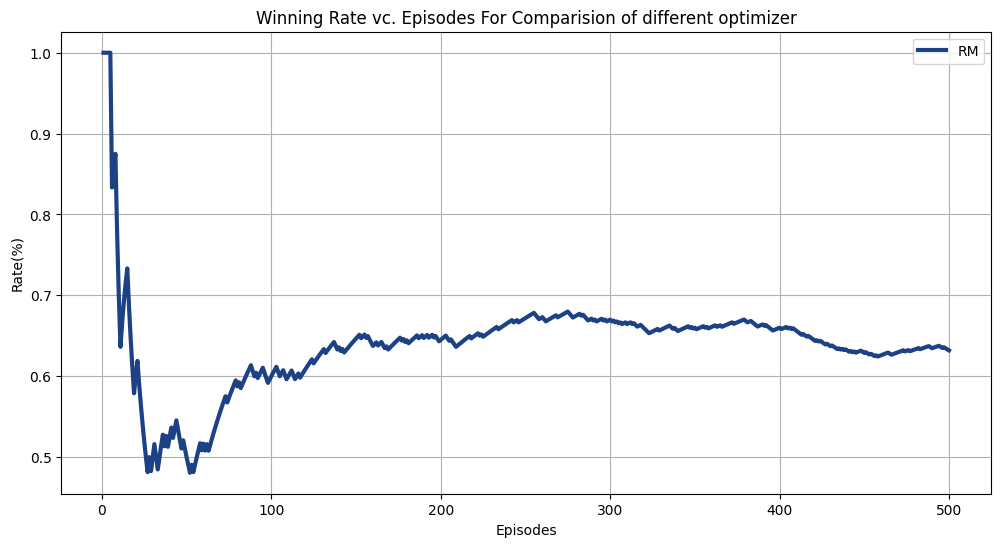

In [ ]:

plt.figure(figsize=(12, 6))  # Set the figure size
#plt.plot(x_axis_version2, win_rate_version2, label='Adam', linewidth = 3, color = '#A2F350')  # Plot the win rate
plt.plot(x_axis_version2_RM, win_rate_version2_RM, label='RM', linewidth = 3, color = '#1c4285')  # Plot the draw rate
plt.xlabel('Episodes')  # Label for x-axis
plt.ylabel('Rate(%)')  # Label for y-axis
plt.title('Winning Rate vc. Episodes For Comparision of different optimizer')  # Title of the plot
plt.legend()  # Add a legend
plt.grid(True)  # Add grid for better readability
plt.savefig('winning_rate_version2_plot.png')  # Save the second plot as a PNG file
plt.show()  # Display the plot



## **Plot**

In [ ]:

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(x_axis_version2, lose_rate_version2, label='Lose', linewidth = 3, color = '#F35050')  # Plot the lose rate
plt.plot(x_axis_version2, win_rate_version2, label='Win', linewidth = 3, color = '#A2F350')  # Plot the win rate
plt.plot(x_axis_version2, draw_rate_version2, label='Draw', linewidth = 3, color = '#1c4285')  # Plot the draw rate
plt.xlabel('Episodes')  # Label for x-axis
plt.ylabel('Rate(%)')  # Label for y-axis
plt.title('Winning Rate vc. Episodes For Baseline')  # Title of the plot
plt.legend()  # Add a legend
plt.grid(True)  # Add grid for better readability
plt.savefig('winning_rate_version2_plot.png')  # Save the second plot as a PNG file
plt.show()  # Display the plot



## **Save Result**

In [ ]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Assuming DDQNAgent and TicTacToeEnv are defined and initialized

In [ ]:
# save data
data_compare_version2 = {
    'Episodes': x_axis_version2,
    'Win Rate': win_rate_version2,
    'Lose Rate': lose_rate_version2,
    'Draw Rate': draw_rate_version2
}
df_compare_version2 = pd.DataFrame(data_compare_version2)
df_compare_version2.to_csv('winning_rate_baseline_data_version2.csv', index=False)  # Save as CSV

*Both use random policy*

In [ ]:
#Train agent vs same actor-critic agent
# Initialize Environment and Agent
env = EnergyTicTacToeEnv()
agent = ActorCriticAgent(env.full_state_size, env.grid_action_size, env.energy_action_size, buffer_size, batch_size, learning_rate, epsilon, epsilon_decay, min_epsilon)

# Variables to track the number of wins, losses, and draws
player_1_wins, player_2_wins, draws = 0, 0, 0  # Reset the win/draw counters

for episode in range(total_training_episodes):
    state = env.reset()
    state = np.reshape(state, [1, env.full_state_size])
    while True:
        state = next_state
        action = random_policy(env)
        next_state, reward, done, _ = env.step(action)


        if done:
            winner = env.check_winner()
            if winner == 1:
                player_1_wins += 1
            elif winner == -1:
                player_2_wins += 1
            else:
                draws += 1
            break

    # Replay and Update the target model
    if len(agent.memory) > agent.batch_size:
        agent.replay()

    print(f"Episode {episode + 1}: Player 1 Wins - {player_1_wins}, Player 2 Wins - {player_2_wins}, Draws - {draws}, Reward - {reward}")

model_save_path = 'actor_critic_tictactoe'
agent.save(model_save_path)
print("Training completed and model saved.")

Episode 1: Player 1 Wins - 1, Player 2 Wins - 0, Draws - 0, Reward - 0.99
Episode 2: Player 1 Wins - 1, Player 2 Wins - 1, Draws - 0, Reward - -1.03
Episode 3: Player 1 Wins - 1, Player 2 Wins - 2, Draws - 0, Reward - -1.02
Episode 4: Player 1 Wins - 1, Player 2 Wins - 3, Draws - 0, Reward - -1.02
Episode 5: Player 1 Wins - 1, Player 2 Wins - 4, Draws - 0, Reward - -1.03
Episode 6: Player 1 Wins - 2, Player 2 Wins - 4, Draws - 0, Reward - 1.01
Episode 7: Player 1 Wins - 2, Player 2 Wins - 5, Draws - 0, Reward - -1.01
Episode 8: Player 1 Wins - 3, Player 2 Wins - 5, Draws - 0, Reward - 1.03
Episode 9: Player 1 Wins - 3, Player 2 Wins - 6, Draws - 0, Reward - -1.0
Episode 10: Player 1 Wins - 4, Player 2 Wins - 6, Draws - 0, Reward - 1.01
Episode 11: Player 1 Wins - 5, Player 2 Wins - 6, Draws - 0, Reward - 1.02
Episode 12: Player 1 Wins - 5, Player 2 Wins - 7, Draws - 0, Reward - -0.99
Episode 13: Player 1 Wins - 5, Player 2 Wins - 8, Draws - 0, Reward - -1.02
Episode 14: Player 1 Wins -